In [1]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Reshape, BatchNormalization
from tensorflow.keras.layers import Input, concatenate, Activation, Conv2DTranspose, UpSampling2D
from tensorflow.keras.applications import VGG16, vgg16, ResNet50
import tensorflow.keras.backend as kb
from tensorflow.keras.regularizers import l2

import matplotlib.pyplot as plt
import numpy as np
import pickle
import os
import cv2
import scipy.io
from skimage import color

from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.transform import resize

In [3]:
import skimage
print(skimage.__version__)

0.16.2


In [2]:
!pip install scikit-image==0.17.2

     |████████████████████████████████| 12.4MB 5.4MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scikit-image 0.16.2
    Uninstalling scikit-image-0.16.2:
      Successfully uninstalled scikit-image-0.16.2


In [2]:
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.3.0
Running on TPU  ['10.79.214.178:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.79.214.178:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.79.214.178:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
gamut = np.load('/content/drive/MyDrive/Junior Year/COS 429 - Team Project/pts_in_hull.npy')
nn = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(gamut)

In [5]:
weights = np.load('/content/drive/MyDrive/Junior Year/COS 429 - Team Project/weight.npy')

weights = list(weights)
print(weights)

[32692.332, 11532.902, 2771.073, 605.7442, 1681.4673, 44785.54, 6297.0566, 2123.261, 814.7885, 530.36633, 327.4133, 283.70795, 1234.7217, 17054.824, 2514.61, 711.60846, 304.45456, 182.73027, 119.63076, 87.89746, 99.889915, 221.69066, 1341.28, 3814.037, 846.6636, 287.67728, 115.06888, 66.84124, 46.48236, 33.622704, 23.838528, 22.601885, 37.682274, 97.4023, 528.46124, 2064.901, 97.632, 36.90972, 27.697916, 18.81267, 13.949824, 10.060441, 6.568106, 5.218928, 6.635826, 13.080772, 39.560966, 221.5024, 7999.965, 1791.1654, 73.88461, 14.697856, 7.882602, 6.504739, 5.30758, 3.6577148, 2.2163224, 1.6621107, 1.8051032, 2.8322327, 6.497948, 20.946783, 106.1173, 2309.2488, 2036.9071, 61.83567, 9.721739, 4.2482567, 2.8006277, 2.2552273, 1.6711773, 1.1014158, 0.87275606, 0.88753355, 1.1489667, 2.0113451, 4.8732047, 14.188706, 41.108223, 290.12454, 69.43365, 7.7987857, 2.7812498, 1.6411736, 1.1473422, 0.8872179, 0.7398735, 0.66848093, 0.66865766, 0.7656106, 1.0837915, 2.0079954, 4.260345, 8.231727, 1

In [6]:
(X_train_orig, y_train_orig), (X_test_orig, y_test_orig) = tf.keras.datasets.cifar10.load_data()

lab_train = color.rgb2lab(X_train_orig)
lab_test = color.rgb2lab(X_test_orig)

170500096/170498071 [==============================] - 2s 0us/step


In [46]:
X_train = np.expand_dims(lab_train[:, :, :, 0], axis=-1)
X_test = np.expand_dims(lab_test[:, :, :, 0], axis=-1)

X_train = np.concatenate((X_train, X_test), axis=0)

y_train = lab_train
y_test = lab_test

y_train = np.concatenate((y_train, y_test), axis=0)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(60000, 32, 32, 1)
(60000, 32, 32, 3)
(10000, 32, 32, 1)
(10000, 32, 32, 3)


In [8]:
def get_qab1(img_ab, sigma=5, bins=313):
    # gets num_nb nearest neighbors
    batch, h, w, _ = img_ab.shape
    a = np.ravel(img_ab[:, :, :, 1])
    b = np.ravel(img_ab[:, :, :, 2])
    ab = np.vstack((a, b)).T  # now dim (H*W*2)
    distances, idx = nn.kneighbors(ab)

    return idx

In [47]:
train_quant = get_qab1(y_train)
train_quant = train_quant.reshape(y_train.shape[0], y_train.shape[1], y_train.shape[1], 1)
print(train_quant.shape)

(60000, 32, 32, 1)


In [48]:
test_quant = get_qab1(y_test)
test_quant = test_quant.reshape(y_test.shape[0], y_test.shape[1], y_test.shape[1], 1)
print(test_quant.shape)

(10000, 32, 32, 1)


In [50]:
def model_conv_2(img_shape):
    """ 
    img_shape: {tuple} shape of one image (height, width, num_channels)
    output: {model} a tensorflow model
    """

    input = Input(shape=img_shape, name='input')

    x = Conv2D(32, (3, 3), padding='same', input_shape=img_shape, activation='relu', name='conv2d_1')(input)
    x = BatchNormalization(name='batchnorm_1')(x)

    x = Conv2D(32, (3, 3), padding='same',activation='relu', name='conv2d_2')(x)
    x = BatchNormalization(name='batchnorm_2')(x)

    x = Conv2D(64, (3, 3), padding='same',activation='relu', name='conv2d_3')(x)
    x = BatchNormalization(name='batchnorm_3')(x)

    x = Conv2D(64, (3, 3), padding='same',activation='relu', name='conv2d_4')(x)
    x = BatchNormalization(name='batchnorm_4')(x)

    x = Conv2D(128, (3, 3), padding='same',activation='relu', name='conv2d_5')(x)
    x = BatchNormalization(name='batchnorm_5')(x)

    x = Conv2D(128, (3, 3), padding='same',activation='relu', name='conv2d_6')(x)
    x = BatchNormalization(name='batchnorm_6')(x)

    x = Conv2D(256, (3, 3), padding='same',activation='relu', name='conv2d_7')(x)
    x = BatchNormalization(name='batchnorm_7')(x)

    x = Conv2D(256, (3, 3), padding='same',activation='relu', name='conv2d_8')(x)
    x = BatchNormalization(name='batchnorm_8')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_10')(x)
    x = BatchNormalization(name='batchnorm_10')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_11')(x)
    x = BatchNormalization(name='batchnorm_11')(x)

    x = Conv2D(128, (1, 1), padding='same', activation='relu', name='conv2d_14')(x)
    x = BatchNormalization(name='batchnorm_14')(x)

    x = Conv2D(64, (1, 1), padding='same', activation='relu', name='conv2d_12')(x)
    x = BatchNormalization(name='batchnorm_12')(x)

    x = Conv2D(64, (1, 1), padding='same', activation='relu', name='conv2d_13')(x)
    x = BatchNormalization(name='batchnorm_13')(x)

    x = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_14')(x)
    x = BatchNormalization(name='batchnorm_14')(x)

    x = Conv2D(313, (1, 1), padding='same', name='conv2d_15')(x)

    output = Activation(tf.keras.activations.softmax)(x)

    model = Model(
      inputs=(input),
      outputs=output,
      name="conv")
  
    return model

In [55]:
def model_conv(img_shape):
    """ 
    img_shape: {tuple} shape of one image (height, width, num_channels)
    output: {model} a tensorflow model
    """

    input = Input(shape=img_shape, name='input')

    x = Conv2D(32, (3, 3), padding='same', input_shape=img_shape, activation='relu', name='conv2d_1')(input)
    x = BatchNormalization(name='batchnorm_1')(x)

    x = Conv2D(32, (3, 3), padding='same',activation='relu', name='conv2d_2')(x)
    x = BatchNormalization(name='batchnorm_2')(x)

    x = Conv2D(64, (3, 3), padding='same',activation='relu', name='conv2d_3')(x)
    x = BatchNormalization(name='batchnorm_3')(x)

    x = Conv2D(64, (3, 3), padding='same',activation='relu', name='conv2d_4')(x)
    x = BatchNormalization(name='batchnorm_4')(x)

    x = Conv2D(128, (3, 3), padding='same',activation='relu', name='conv2d_5')(x)
    x = BatchNormalization(name='batchnorm_5')(x)

    x = Conv2D(128, (3, 3), padding='same',activation='relu', name='conv2d_6')(x)
    x = BatchNormalization(name='batchnorm_6')(x)

    x = Conv2D(256, (3, 3), padding='same',activation='relu', name='conv2d_7')(x)
    x = BatchNormalization(name='batchnorm_7')(x)

    x = Conv2D(256, (3, 3), padding='same',activation='relu', name='conv2d_8')(x)
    x = BatchNormalization(name='batchnorm_8')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_10')(x)
    x = BatchNormalization(name='batchnorm_10')(x)

    x = Conv2D(128, (3, 3), padding='same', activation='relu', name='conv2d_11')(x)
    x = BatchNormalization(name='batchnorm_11')(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_12')(x)
    x = BatchNormalization(name='batchnorm_12')(x)

    x = Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2d_13')(x)
    x = BatchNormalization(name='batchnorm_13')(x)

    x = Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2d_14')(x)
    x = BatchNormalization(name='batchnorm_14')(x)

    x = Conv2D(313, (3, 3), padding='same', name='conv2d_15')(x)

    output = Activation(tf.keras.activations.softmax)(x)

    model = Model(
      inputs=(input),
      outputs=output,
      name="conv")
  
    return model

In [13]:
def colorful_image(img_shape):
    input = Input(shape=img_shape, name='input')

    l2_reg = l2(1e-3)

    x = Conv2D(16, (3, 3), input_shape=img_shape, kernel_initializer="he_normal", kernel_regularizer=l2_reg, padding='same', activation='relu', name='conv2d_1')(input)
    # x = Conv2D(16, (3, 3), input_shape=img_shape, kernel_initializer="he_normal", kernel_regularizer=l2_reg, padding='same',activation='relu', name='conv2d_11')(x)
    x = BatchNormalization(name='batchnorm_1')(x)

    x = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_2')(x)
    # x = Conv2D(32, (3, 3), padding='same', kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_22')(x)
    x = BatchNormalization(name='batchnorm_2')(x)

    x = Conv2D(64, (3, 3),padding='same', kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_3')(x)
    # x = Conv2D(64, (3, 3),padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_33')(x)
    x = BatchNormalization(name='batchnorm_3')(x)

    x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_4')(x)
    # x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_44')(x)
    # x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_444')(x)
    x = BatchNormalization(name='batchnorm_4')(x)

    x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_5', dilation_rate=2)(x)
    # x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_55', dilation_rate=2)(x)
    # x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_555', dilation_rate=2)(x)
    x = BatchNormalization(name='batchnorm_5')(x)

    x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_6',  dilation_rate=2)(x)
    # x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_66',  dilation_rate=2)(x)
    # x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_666',  dilation_rate=2)(x)
    x = BatchNormalization(name='batchnorm_6')(x)

    x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg, activation='relu', name='conv2d_7')(x)
    # x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg,  activation='relu',name='conv2d_77')(x)
    x = Conv2D(128, (3, 3), padding='same',kernel_initializer="he_normal", kernel_regularizer=l2_reg,  name='conv2d_777')(x)

    output = Conv2D(313, (1, 1), padding='same', activation='softmax', name='conv2d_15')(x)

    model = Model(
      inputs=(input),
      outputs=output,
      name="conv")
  
    return model



In [ ]:
model = colorful_image((32,32,1))
print(model.summary())

Model: "conv"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        160       
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batchnorm_3 (BatchNormalizat (None, 32, 32, 64)        256    

In [41]:
def categorical_crossentropy_1hot(y_true, y_pred):
    q = 313
    # y_true = kb.reshape(y_true, (-1, 1))
    weights = kb.constant([32692.332, 11532.902, 2771.073, 605.7442, 1681.4673, 44785.54, 6297.0566, 2123.261, 814.7885, 530.36633, 327.4133, 283.70795, 1234.7217, 17054.824, 2514.61, 711.60846, 304.45456, 182.73027, 119.63076, 87.89746, 99.889915, 221.69066, 1341.28, 3814.037, 846.6636, 287.67728, 115.06888, 66.84124, 46.48236, 33.622704, 23.838528, 22.601885, 37.682274, 97.4023, 528.46124, 2064.901, 97.632, 36.90972, 27.697916, 18.81267, 13.949824, 10.060441, 6.568106, 5.218928, 6.635826, 13.080772, 39.560966, 221.5024, 7999.965, 1791.1654, 73.88461, 14.697856, 7.882602, 6.504739, 5.30758, 3.6577148, 2.2163224, 1.6621107, 1.8051032, 2.8322327, 6.497948, 20.946783, 106.1173, 2309.2488, 2036.9071, 61.83567, 9.721739, 4.2482567, 2.8006277, 2.2552273, 1.6711773, 1.1014158, 0.87275606, 0.88753355, 1.1489667, 2.0113451, 4.8732047, 14.188706, 41.108223, 290.12454, 69.43365, 7.7987857, 2.7812498, 1.6411736, 1.1473422, 0.8872179, 0.7398735, 0.66848093, 0.66865766, 0.7656106, 1.0837915, 2.0079954, 4.260345, 8.231727, 14.697401, 88.10616, 123.56377, 8.549213, 2.0607886, 1.0287431, 0.7337245, 0.58339643, 0.5325286, 0.5427769, 0.5741582, 0.63359207, 0.7972011, 1.2194233, 2.0938044, 3.4885461, 5.844843, 14.59768, 224.09665, 313.79123, 14.151388, 2.5179718, 1.0601915, 0.74090326, 0.6045285, 0.5248812, 0.50793827, 0.51475036, 0.5384855, 0.5965137, 0.7588944, 1.1414465, 1.8628801, 3.0509567, 5.4980116, 22.528412, 1018.6674, 1167.7639, 33.715576, 5.0022745, 1.8327619, 1.1583166, 0.9227692, 0.7416092, 0.5816683, 0.5300789, 0.5330327, 0.5488049, 0.5905039, 0.7108884, 1.0192196, 1.7134674, 3.1234066, 6.862162, 53.95567, 98.50841, 11.10202, 4.0598183, 2.4690924, 2.0525897, 1.9916863, 1.8360013, 1.2289033, 0.7950196, 0.6519397, 0.6305019, 0.6623881, 0.7775285, 1.072887, 1.799717, 3.5793085, 10.47319, 183.41864, 434.89355, 27.041687, 8.691425, 5.355047, 4.57398, 5.2476964, 6.054767, 4.988905, 3.1622958, 1.7259462, 1.0428593, 0.8667984, 0.87742054, 1.0143344, 1.3630986, 2.2221432, 4.5286417, 18.442816, 736.75616, 2796.7239, 78.949974, 17.526073, 10.9135475, 9.71835, 11.920596, 15.654068, 13.377048, 9.967241, 6.3578634, 3.727995, 2.1082728, 1.3659418, 1.1891056, 1.3834146, 1.8784806, 3.0373712, 6.474711, 40.62569, 3786.0413, 320.98657, 36.712803, 19.803667, 20.619112, 29.894442, 39.230774, 33.334198, 24.409525, 17.805473, 11.222572, 7.036376, 4.191616, 2.4527369, 1.647666, 1.5325255, 2.1887038, 4.0721583, 9.95364, 103.94156, 1869.3508, 95.62695, 37.57686, 41.439983, 77.08542, 105.08935, 90.82194, 61.963383, 44.418964, 30.049143, 19.298674, 13.181697, 8.7182665, 5.0008245, 2.9202373, 2.059343, 2.1413033, 4.296045, 15.0827055, 284.37225, 273.81094, 65.33963, 89.82112, 209.64352, 303.31833, 272.63504, 169.56891, 113.4218, 84.69019, 56.883522, 38.729336, 29.364346, 22.29629, 14.101571, 7.8442273, 4.777419, 3.5526936, 4.5467944, 18.035803, 676.8908, 215.30116, 163.6127, 449.10352, 715.139, 717.79974, 553.0553, 294.80643, 243.3219, 197.97186, 148.64093, 112.09155, 99.2456, 91.17506, 72.32096, 47.066765, 28.656807, 17.786356, 12.416392, 27.490313, 4218.1177, 3486.5208, 3318.3772, 2306.5361, 1566.8556, 680.7541, 546.5457, 564.2634, 642.14026, 767.8787, 753.0141, 960.2971, 1239.6636, 1434.2999, 1300.0032, 1000.7965, 648.57764, 315.42514, 436.99173, 263108.25, 43699.098, 5505.9375, 1138.0339, 2660.6387, 6030.845, 13213.201, 33383.035, 55437.87, 110139.055])

    y_true = kb.flatten(y_true)

    y_pred = kb.reshape(y_pred, (-1, q))
    weights = kb.gather(weights, y_true)
    weights = kb.reshape(weights, (-1, 1))

    y_pred *= weights
    loss = kb.sparse_categorical_crossentropy(y_true, y_pred)

    # print(kb.get_value(y_pred))
    # print(kb.shape(y_pred))

    return loss

In [56]:
with tpu_strategy.scope():
  PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Models'
  MODEL_TYPE = 'Classification/deep_classification_rebalance'

  model = model_conv((32,32,1))

  # stop training once validation loss stops improving
  early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)


  # save the best model
  checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(PATH, f"{MODEL_TYPE}.h5"),
                                                  overwrite=True, save_weights_only=False, 
                                                  monitor='val_loss', mode='min', save_best_only=True)

  callbacks = [early, checkpoint]

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=5e-4), loss=categorical_crossentropy_1hot)



history = model.fit(X_train, train_quant,
            epochs=400, verbose=2,
            validation_split=0.005, batch_size=1024, shuffle=True, callbacks=[callbacks])

Epoch 1/400


59/59 - 27s - loss: 4.9009 - val_loss: 7.6890
Epoch 2/400
59/59 - 11s - loss: 3.8359 - val_loss: 5.0580
Epoch 3/400
59/59 - 10s - loss: 3.2390 - val_loss: 5.7689
Epoch 4/400
59/59 - 10s - loss: 2.9893 - val_loss: 5.6015
Epoch 5/400
59/59 - 10s - loss: 2.8668 - val_loss: 5.2779
Epoch 6/400


KeyboardInterrupt: ignored

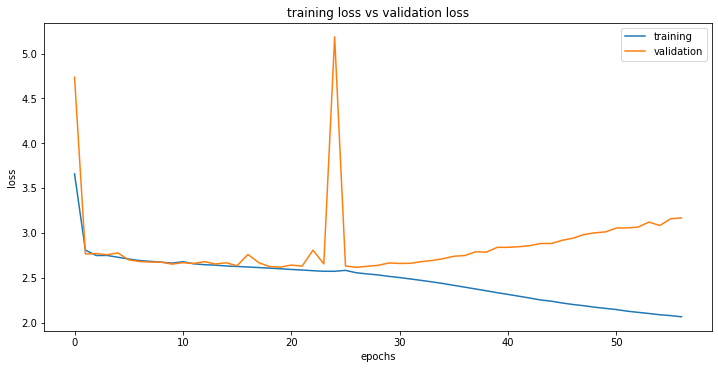

In [44]:
model_history(history, 10)

In [20]:
def annealed_softmax(qab, temperature=0.38):
  expon = qab** (1/temperature)
  expon /= np.sum(expon, axis=-1, keepdims=True)
  
  return expon

def annealed_mean(qab, temperature=0.38):
  qab = annealed_softmax(qab, temperature)
  am = np.dot(qab, gamut)
  
  return am

In [34]:
PATH = '/content/drive/MyDrive/Junior Year/COS 429 - Team Project/Models'
MODEL_TYPE = 'Classification/deep_classification_norebalance'

model = tf.keras.models.load_model(os.path.join(PATH, f"{MODEL_TYPE}.h5"), custom_objects={'categorical_crossentropy_1hot': categorical_crossentropy_1hot})

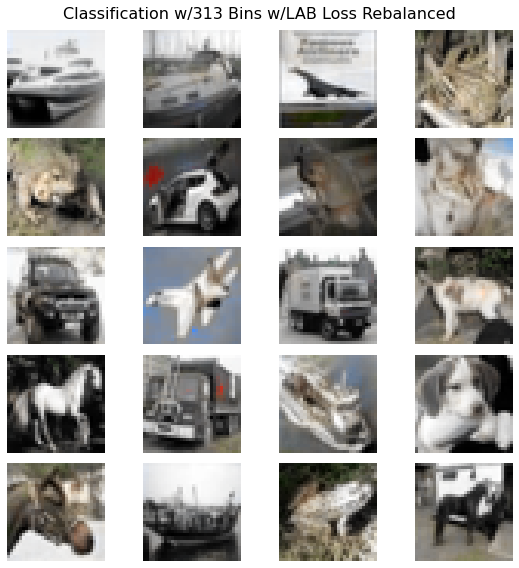

In [54]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5

for i in range(1, columns*rows +1):
  fig.add_subplot(rows, columns, i)
  
  im_in = np.expand_dims(X_test[i], axis=0)

  prediction = model.predict(im_in)
  prediction = annealed_mean(prediction)
  prediction = np.concatenate((im_in, prediction), axis=-1)
  prediction = color.lab2rgb(prediction.squeeze())

  prediction = (prediction - np.min(prediction)) / (np.max(prediction) - np.min(prediction))

  plt.imshow(prediction.squeeze())

  # plt.imshow(X_test_orig[i])

  plt.axis('off')

fig.tight_layout()  
plt.subplots_adjust(top=.94)
fig.suptitle('Classification w/313 Bins w/LAB Loss Rebalanced', fontsize=16)
plt.show()

In [18]:
def __display_training_curves(training, validation, subplot):
    """
    summary: helper function for plotting the model history
    """
    ax = plt.subplot(subplot)
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('training loss vs validation loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epochs')
    ax.legend(['training', 'validation'])

def model_history(history, size=10):
    """
    history: {history} tensorflow history object
    size: {size} size of viewing window

    summary: plots the model history (training vs. validation loss)
    """
    plt.subplots(figsize=(size, size))
    plt.tight_layout()
    __display_training_curves(history.history['loss'], history.history['val_loss'], 211)
  